<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/Exophthalmos_iFish_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hertel estimation iFish YOLOv5**

Train YOLOv5 using iFish augmentation

```
iFish: https://github.com/Gil-Mor/iFish.git

yolov5_iFish: https://github.com/ykitaguchi77/yolov5-iFish.git
※ FishAugment(distortion_range=(0, 0.3), p=0.5)

```

```
Olympia dataset
Dlibで目が2つ検出されるものを抜き出す
YOLOv5を用いて左右とバウンディングボックスを認識させる
その画像に関して、YOLOv5でそのまま回帰を試みる
スマホに実装
```

Output as CoreML

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys
import torch
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow


import glob
import random
from PIL import Image
%matplotlib inline

# #サポートパッチのインポート
# from google.colab.patches import cv2_imshow
# import cv2

plt.ion()   # interactive mode
!nvidia-smi
print(torch.cuda.is_available())


In [ ]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.89

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#親フォルダ
parent_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5'

#元画像フォルダ
dataset_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset'

#元画像をコピー
orig_dir = f"{parent_dir}/dataset_orig"

#切りぬいた画像を保存するフォルダ
out_dir = f"{parent_dir}/dataset_uni"

#CSVファイルのフォルダ
csv_hertel_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel.csv"
csv_coordinate_path = f"{parent_dir}/coordinate_uni_for_YOLO5.csv"
csv_integrated_path = f"{parent_dir}/integrated_uni_for_YOLO5.csv"

In [ ]:
"""
###################################
# Reflesh folder (内容が削除されるので注意！！) #
###################################
"""

# parent_dirがあれば削除する
if os.path.exists(parent_dir):
    shutil.rmtree(parent_dir)

# 新しくparent_dirを作成する
os.makedirs(parent_dir)

# orig_dir, out_dirを新規に作成する
os.makedirs(orig_dir)
os.makedirs(out_dir)

# orig_dirにdataset_dir直下のファイルをすべてコピーする
file_list = os.listdir(dataset_dir)
for filename in tqdm(file_list, desc="Copying files", unit="file"):
    src_path = os.path.join(dataset_dir, filename)
    dst_path = os.path.join(orig_dir, filename)
    shutil.copy(src_path, dst_path)

print("処理が完了しました。")


Copying files: 100%|██████████| 1016/1016 [00:42<00:00, 23.86file/s]

処理が完了しました。


#**HaarCascadeを用いて目を検出**

In [ ]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#**目が2つ以上検出されたものを抜き出す**

dlibで検出されたものから、上下左右に0.1倍ずつ拡大した範囲を抜き出している

In [ ]:
with open(csv_coordinate_path, 'w', newline='') as f:
        #fieldnames = ['Number', 'Folder', 'FileName']
        writer = csv.writer(f)
        writer.writerow(['id','img_path', 'side R/L', 'ex', 'ey', 'ew', 'eh'])  #header

        files = os.listdir(orig_dir)

        k=0
        for file in files:  #フォルダ数の分だけ
              file_path = f"{orig_dir}/{file}"
              id = os.path.splitext(os.path.basename(file_path))[0]

              img = cv2.imread(file_path)
              img2 = img.copy()

              # 画像グレースケール化
              grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

              #300pix以上のもので目に見えるものを抽出
              eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))

              # 眼検出判定
              if len(eye_list) >= 1:
                  print('目が' + str(len(eye_list)) +'個検出されました')
              else:
                  print("eye detection error")

              #画像の切り抜きと保存（2個以上検出の時に限る）
              if len(eye_list) >= 2:
                  for (ex, ey, ew, eh) in eye_list:
                      print(f"img_width: {img2.shape[1]}")
                      print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                      cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                      img_cropped = img[int(ey-0.1*eh): int(ey+1.1*eh), int(ex-0.1*ew): int(ex+1.1*ew)] #本来の切り抜きより幅の0.1倍ずつ水増しする
                      #img_cropped = img[int(ey): int(ey+eh), int(ex): int(ex+ew)]


                      if ex+eh*0.5 <= img2.shape[1]/2:
                          side = "R" #横幅の半分より左にあるのは右眼
                      else:
                          side = "L" #横幅の半分よりより右にあるのは左眼

                      print(f"side: {side}")
                      print("")

                      # Check if coordinates are within the image bounds
                      ey_start = max(int(ey - 0.1 * eh), 0)
                      ey_end = min(int(ey + 1.1 * eh), img.shape[0])
                      ex_start = max(int(ex - 0.1 * ew), 0)
                      ex_end = min(int(ex + 1.1 * ew), img.shape[1])

                      # Ensure we have a valid crop area
                      if ex_start < ex_end and ey_start < ey_end:
                          img_cropped = img[ey_start: ey_end, ex_start: ex_end]

                          # Now do the checks for the right/left side, write image and row
                          # ...

                          cv2.imwrite(f"{out_dir}/{id}_{side}.png", img_cropped)

                      #対応表の作成
                      writer.writerow([id, file_path, side, ex+round(ew/2), ey+round(eh/2), ew, eh])

                      #cv2_imshow(img_cropped)
                  else:
                      pass


##**ここで、目以外が誤検出されているものを手動で抜き出して削除する**

```
coordinate_uni_for_YOLO5.csvから、削除して画像のパスが存在しなくなっている行を削除する

```

In [ ]:
import os
import pandas as pd

# DataFrameを読み込む
coordinates_df = pd.read_csv(csv_coordinate_path)

# 存在しない画像パスをチェックし、そのリストを保持する
nonexistent_paths = coordinates_df[~coordinates_df['img_path'].apply(os.path.exists)]

# 存在しない画像パスを表示
print("Nonexistent image paths:")
print(nonexistent_paths['img_path'])

# # 存在しない画像パスの行を削除
# coordinates_df = coordinates_df[coordinates_df['img_path'].apply(os.path.exists)]

# # 更新されたDataFrameを保存する
# coordinates_df.to_csv('coordinate_uni_for_YOLO5.csv', index=False)


Nonexistent image paths:
Series([], Name: img_path, dtype: object)


##**Dataframeの整理**

・ hertel_dfを参照して、coordinates_dfにヘルテル値を記入する

・idが"16_R, 16_L"という形式になるようにデータフレームを整理する

In [6]:
import pandas as pd

# Assuming csv_coordinate_path and csv_hertel_path are defined paths to the CSV files
coordinates_df = pd.read_csv(csv_coordinate_path)
hertel_df = pd.read_csv(csv_hertel_path)

coordinates_df['Hertel'] = None

def get_hertel_value(row, hertel_df):
    id = row['id']
    side = row['side R/L']
    hertel_value = hertel_df.loc[hertel_df['number'] == id, side].values
    return hertel_value[0] if len(hertel_value) > 0 else None

# Use .copy() to ensure that you're working with a copy and not a view
coordinates_df['Hertel'] = coordinates_df.apply(lambda row: get_hertel_value(row, hertel_df), axis=1)

id_counts = coordinates_df.groupby('id')['side R/L'].value_counts().unstack()
valid_ids = id_counts[(id_counts['R'] == 1) & (id_counts['L'] == 1)].index

# Filter the DataFrame to only include these ids
# Use .copy() to avoid SettingWithCopyWarning when modifying this DataFrame later
coordinates_filtered_df = coordinates_df[coordinates_df['id'].isin(valid_ids)].copy()
coordinates_filtered_df.reset_index(drop=True, inplace=True)

coordinates_filtered_df.to_csv(csv_integrated_path, index=False)
coordinates_filtered_df.head()

,id,img_path,side R/L,ex,ey,ew,eh,Hertel
0,19,/content/drive/MyDrive/Deep_learning/Olympia_d...,R,525,975,696,696,15.0
1,19,/content/drive/MyDrive/Deep_learning/Olympia_d...,L,1938,972,708,708,16.0
2,20,/content/drive/MyDrive/Deep_learning/Olympia_d...,R,544,953,785,785,18.0
3,20,/content/drive/MyDrive/Deep_learning/Olympia_d...,L,1978,976,815,815,18.0
4,21,/content/drive/MyDrive/Deep_learning/Olympia_d...,R,581,989,723,723,19.0


In [13]:
'''
画像パスの抽出（RLともに揃っているもの）
'''
coordinates_filtered_df = coordinates_filtered_df.drop_duplicates(subset='id', keep='first')
img_path_list = coordinates_filtered_df['img_path'].tolist()


'''
画像の分割 train:valid = 8:2
'''
random.seed(42)  # For reproducibility
random.shuffle(img_path_list)

split_index = int(0.8 * len(img_path_list))
train_img_paths = img_path_list[:split_index]
valid_img_paths = img_path_list[split_index:]

if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
    os.makedirs(out_dir)

'''
フォルダの作成
'''
folders = ['train/images', 'train/labels', 'valid/images', 'valid/labels']
for folder in folders:
    os.makedirs(os.path.join(out_dir, folder))


'''
画像のコピー
'''
# Define paths for images directories
train_images_dir = os.path.join(out_dir, 'train/images')
valid_images_dir = os.path.join(out_dir, 'valid/images')

# Copy training images
for img_path in tqdm(train_img_paths, desc='Copying train images'):
    shutil.copy(img_path, train_images_dir)

# Copy validation images
for img_path in tqdm(valid_img_paths, desc='Copying valid images'):
    shutil.copy(img_path, valid_images_dir)

Copying valid images: 100%|██████████| 190/190 [02:44<00:00,  1.16it/s]


In [ ]:
import os
import pandas as pd
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def convert_to_yolo_format(ex, ey, ew, eh, img_width, img_height):
    cx = (ex + (ew / 2)) / img_width
    cy = (ey + (eh / 2)) / img_height
    w = ew / img_width
    h = eh / img_height
    return cx, cy, w, h

def create_label_files(image_dir, label_dir, df):
    image_files = os.listdir(image_dir)
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        img_width, img_height = get_image_dimensions(image_path)

        base_name = os.path.splitext(image_file)[0]
        matched_rows = df[df['id'] == int(base_name)]

        if matched_rows.empty:
            raise ValueError(f"No matching id found for image {image_file}")

        label_file_path = os.path.join(label_dir, f"{base_name}.txt")
        with open(label_file_path, 'w') as label_file:
            for _, row in matched_rows.iterrows():
                ex = row['ex']
                ey = row['ey']
                ew = row['ew']
                eh = row['eh']
                cx, cy, w, h = convert_to_yolo_format(ex, ey, ew, eh, img_width, img_height)
                side = 0 if row['side R/L'] == 'R' else 1
                label_file.write(f"{cx} {cy} {w} {h} {side}\n")
                #label_file.write(f"{ex} {ey} {ew} {eh} {side}\n")

# CSVファイルの読み込み
csv_integrated_df = pd.read_csv(csv_integrated_path)

# trainとvalidのディレクトリパス
train_images_dir = os.path.join(out_dir, "train/images")
train_labels_dir = os.path.join(out_dir, "train/labels")
valid_images_dir = os.path.join(out_dir, "valid/images")
valid_labels_dir = os.path.join(out_dir, "valid/labels")

# trainディレクトリでラベルファイルを生成
create_label_files(train_images_dir, train_labels_dir, csv_integrated_df)

# validディレクトリでラベルファイルを生成
create_label_files(valid_images_dir, valid_labels_dir, csv_integrated_df)


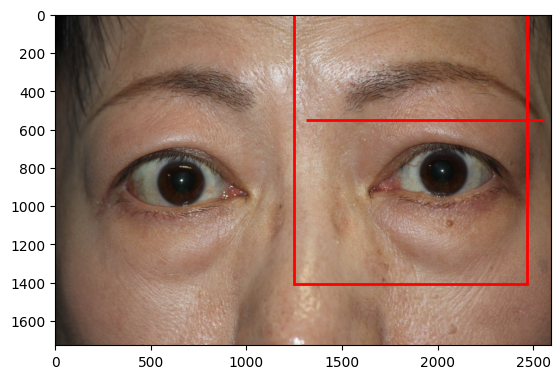

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# バウンディングボックスを描画する関数
def draw_bounding_boxes(image_path, bboxes):
    with Image.open(image_path) as img:
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        for bbox in bboxes:
            cx, cy, bw, bh, class_id = bbox
            x = (cx - bw / 2) * img_width
            y = (cy - bh / 2) * img_height
            width = bw * img_width
            height = bh * img_height
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

# ラベルファイルからバウンディングボックスのリストを取得する関数
def get_bboxes_from_label_file(label_path, img_width, img_height):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            class_id, cx, cy, bw, bh = map(float, line.split())
            bboxes.append((cx, cy, bw, bh, class_id))
    return bboxes

# 画像パスとラベルファイルパス
image_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/images/10.JPG"
label_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/labels/10.txt"

# 画像のサイズを取得
img_width, img_height = get_image_dimensions(image_path)

# ラベルファイルからバウンディングボックスのリストを取得
bboxes = get_bboxes_from_label_file(label_path, img_width, img_height)

# バウンディングボックスを描画
draw_bounding_boxes(image_path, bboxes)


In [ ]:
print(f"train_images: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/images'))}")
print(f"val_images: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/images'))}")
print(f"train_labels: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels'))}")
print(f"val_labels: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/labels'))}")

def check_basename(image_dir, label_dir):
    # 画像ファイルのベースネーム一覧を取得
    image_files = [os.path.splitext(file)[0] for file in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, file))]
    image_files = set(image_files)  # 重複を削除

    # ラベルファイルのベースネーム一覧を取得
    label_files = [os.path.splitext(file)[0] for file in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, file))]
    label_files = set(label_files)  # 重複を削除

    # ファイルのベースネームが完全に一致するか確認
    match = image_files == label_files

    if match:
        print("すべてのファイルのベースネームが一致しています。")
    else:
        print("ファイルのベースネームが一致していません。")

check_basename('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/images', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels')
check_basename('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/images', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/labels')

train_images: 3498
val_images: 795
train_labels: 3498
val_labels: 795
すべてのファイルのベースネームが一致しています。
すべてのファイルのベースネームが一致しています。


In [ ]:
import os

directory = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels'

# ディレクトリ内のファイルを取得
files = os.listdir(directory)

# テキストファイルを読み込んで表示
for file in files:
    if file.endswith('.txt'):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            content = f.read().strip()
            if content:
                print(f"ファイル名: {file}\n内容: {content}\n")
            else:
                print(f"ファイル名: {file}\nエラー: ファイルの内容が空欄です。\n")
                sys.exit(1)  # プログラムを中止


#**Albumentationによるデータ拡張**

(YOLOv5-iFish https://github.com/ykitaguchi77/yolov5-iFish.git に組み込み済み)

In [ ]:
import random
import numpy as np
from albumentations import DualTransform
from math import sqrt
import albumentations as A


class FishEyeEffect(DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(FishEyeEffect, self).__init__(always_apply, p)
        self.image_shape = None  # Initialize the instance variable to store image shape


    def get_fish_xn_yn(self, source_x, source_y, radius, distortion):
        if 1 - distortion*(radius**2) == 0:
            return source_x, source_y
        return source_x / (1 - (distortion*(radius**2))), source_y / (1 - (distortion*(radius**2)))

    def get_original_xn_yn(self, dest_x, dest_y, radius, distortion):
        return dest_x * (1 - distortion * (radius**2)), dest_y * (1 - distortion * (radius**2))


    def apply(self, img, distortion=0, **params):
        self.image_shape = img.shape  # set image shape here
        # your fish-eye effect implementation here
        dstimg = np.zeros_like(img)
        w, h = float(img.shape[0]), float(img.shape[1])
        for x in range(len(dstimg)):
            for y in range(len(dstimg[x])):
                xnd, ynd = float((2*x - w)/w), float((2*y - h)/h)
                rd = sqrt(xnd**2 + ynd**2)
                xdu, ydu = self.get_fish_xn_yn(xnd, ynd, rd, distortion)
                xu, yu = int(((xdu + 1)*w)/2), int(((ydu + 1)*h)/2)
                if 0 <= xu < img.shape[0] and 0 <= yu < img.shape[1]:
                    dstimg[x][y] = img[xu][yu]
        return dstimg

    def apply_to_bbox(self, bbox, distortion=0, **params):
        img_h, img_w = self.image_shape[:2]  # Use the stored image shape

        # YOLO形式から4つの角の座標を取得
        x_min, y_min, x_max, y_max = bbox

        # 4つの角の座標を正規化
        corners = [(x_min, y_min),
                  (x_max, y_min),
                  (x_min, y_max),
                  (x_max, y_max)]

        # 正規化された座標を魚眼変換用に変換
        corners = [(2*x - 1, 2*y - 1) for x, y in corners]

        print("Transformed corners:", corners)

        # 各角をFishEyeで逆変換
        distorted_corners = [self.get_original_xn_yn(x, y, sqrt(x**2 + y**2), distortion) for x, y in corners]

        print("Distorted corners:", distorted_corners)

        # 逆変換された点を含む最小の長方形を求める
        x_min_new = min(x for x, y in distorted_corners)
        x_max_new = max(x for x, y in distorted_corners)
        y_min_new = min(y for x, y in distorted_corners)
        y_max_new = max(y for x, y in distorted_corners)

        # 魚眼逆変換後の座標を画像座標系に戻す
        x_min_new = (x_min_new + 1) / 2
        x_max_new = (x_max_new + 1) / 2
        y_min_new = (y_min_new + 1)  / 2
        y_max_new = (y_max_new + 1)  / 2

        print(x_min_new, y_min_new, x_max_new, y_max_new)

        return x_min_new, y_min_new, x_max_new, y_max_new


    def get_params(self):
        # Random distortion coefficient between 0 and 0.3
        return {'distortion': random.uniform(0, 0.3)}


# 変換する関数を定義
transform = A.Compose([
    #A.RandomCrop(width=400, height=400),
    FishEyeEffect(p=1),
    #A.HorizontalFlip(p=1),
    #A.VerticalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
], bbox_params=A.BboxParams(format='yolo',min_area=1024,
min_visibility=0.1, label_fields=['class_labels']))



# 画像読み込み
image = cv2.imread("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/images/1043.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# yoloのアノテーションファイルを読み込み
f = open('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels/1043.txt', 'r')
anno_lists = f.readlines()
f.close()

# 空の配列を用意
bboxes = []
class_labels = []

# アノテーションファイルをパイプラインに与える形に変換
for anno_list in anno_lists:
    # スペースで区切る
    anno_list = anno_list.split()

    # 0番目の要素からクラスラベルを取り出し
    class_labels.append(anno_list[0])

    # BBoxの値をfloatに変換
    anno_list = [float(i) for i in anno_list[1:]]

    # BBoxの配列に追加
    bboxes.append(anno_list)


# 変換を実行し、変換後のimage, bboxes, class_labelsを取得
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']



# 関数：YOLO形式のバウンディングボックスをmatplotlibのrectangleに変換
def yolo_to_rect(bbox, img_shape):
    cx, cy, w, h = bbox
    img_h, img_w = img_shape[:2]
    tlx = int((cx - w/2) * img_w)
    tly = int((cy - h/2) * img_h)
    rect_w = int(w * img_w)
    rect_h = int(h * img_h)
    return tlx, tly, rect_w, rect_h

# 元の画像とバウンディングボックスを表示
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
for bbox in bboxes:
    tlx, tly, rect_w, rect_h = yolo_to_rect(bbox, image.shape)
    rect = plt.Rectangle((tlx, tly), rect_w, rect_h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.title('Before Augmentation')

# 変換後の画像とバウンディングボックスを表示
plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.axis('off')
for bbox in transformed_bboxes:
    tlx, tly, rect_w, rect_h = yolo_to_rect(bbox, transformed_image.shape)
    rect = plt.Rectangle((tlx, tly), rect_w, rect_h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.title('After Augmentation')

plt.show()


# # To save the transformed annotations:
# with open('result.txt', 'w') as f:
#     for i, transformed_bbox in enumerate(transformed_bboxes):
#         f.write("{} {} {} {} {}\n".format(
#             transformed_class_labels[i],
#             transformed_bbox[0], transformed_bbox[1],
#             transformed_bbox[2], transformed_bbox[3]
#         ))



#**Setup YOLOv5**

In [ ]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training
!git clone https://github.com/ykitaguchi77/yolov5-iFish.git #iFish augmentationを実装したバージョン
%cd yolov5-iFish
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

#**Train YOLOv5**

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 300 --data /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/dataset.yaml --weights yolov5n.pt


In [ ]:
# 途中から
!python train.py --img 640 --batch 16 --epochs 300 --data /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/dataset.yaml --resume /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/last.pt


In [ ]:
# best.pyをrenameしてgdriveに移動しておく
orig_pt = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
dst_pt = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
shutil.copy(orig_pt, dst_pt)

'/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt'

#**Show examples**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob

val_images_dir = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/images"
val_labels_dir = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/labels"

for sample_num in range(21):
    sample_image_path = glob.glob(f"{val_images_dir}/*")[sample_num]
    sample_label_path = glob.glob(f"{val_labels_dir}/*")[sample_num]

    # 画像の読み込み
    image = cv2.imread(sample_image_path)
    height, width = image.shape[:2]
    image = cv2.resize(image, (640, int(height * 640 / width)))

    # バウンディングボックスの情報
    with open(sample_label_path, "r", encoding="utf-8") as file:
        content = file.read()
    content_list = content.split()

    # バウンディングボックスの座標を計算
    x = float(content_list[1]) * image.shape[1]
    y = float(content_list[2]) * image.shape[0]
    box_width = float(content_list[3]) * image.shape[1]
    box_height = float(content_list[4]) * image.shape[0]

    # バウンディングボックスの座標を計算
    left = int(x - (box_width / 2))
    top = int(y - (box_height / 2))
    right = int(x + (box_width / 2))
    bottom = int(y + (box_height / 2))

    # バウンディングボックスを画像に重ねる
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

    # 画像の表示
    cv2_imshow(image)


#**Interference Olympia dataset**

In [ ]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish

import torch
import utils
%pip install -qr requirements.txt
display = utils.notebook_init()

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.5/166.8 GB disk)


In [ ]:
# YOLOv5
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolov5n_130epch.pt"

# 横幅を640pxにリサイズしたデータセット
dataset_olympia_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav"
dataset_olympia_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont"
dataset_handai_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/grav"
dataset_handai_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/cont"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob


image_path = glob.glob(f"{dataset_olympia_grav}/*")
start_index = 1
end_index = 5

class_names = {0: "cont", 1: "grav"}

for i in range(start_index, end_index + 1):
    img = image_path[i]

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" % (class_name, prob * 100))

    img_cv2 = cv2.imread(img)
    img_cv2 = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height)) / 2
    padding_y = (img_width - min(img_width, img_height)) / 2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    cv2_imshow(img_cv2)


In [ ]:
#Testsetの正解率を確認
import cv2
from google.colab.patches import cv2_imshow
import glob

class_names = {0: "cont", 1: "grav"}



def interference_testset(image_path, answer):
    pred_list = []
    correct_list = [] #正解なら1、不正解なら0

    for img in image_path:
        pred = interference(img, weight)

        # output result
        x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

        # probability
        prob = pred[0][0][4].item()

        # class
        class_name = class_names[pred[0][0][5].item()]

        if class_name == answer:
            correct_list.append(1)
        else:
            correct_list.append(0)

        print("診断は %s、確率は%.1f％です。" % (class_name, prob * 100))

    total_count = len(correct_list)
    one_count = correct_list.count(1)
    percentage = (one_count / total_count) * 100
    print("")
    print(f"image_path: {image_path}")
    print(f"The percentage of corrects in the list is: {percentage:.2f}%")
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")

interference_testset(glob.glob(f"{dataset_olympia_grav}/*"), "grav")
interference_testset(glob.glob(f"{dataset_olympia_cont}/*"), "cont")
interference_testset(glob.glob(f"{dataset_handai_grav}/*"), "grav")
interference_testset(glob.glob(f"{dataset_handai_cont}/*"), "cont")


#**Export coreML including non-max supression**

In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"

In [ ]:
#!python export.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt --nms --include coreml
!python export.py --weights $weight_path --nms --include "coreml"


In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/hietalajulius/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements-export.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
!python export-nms.py --include coreml --weights $weight_path


#**Interference and crop Extended dataset**

In [ ]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.9/166.8 GB disk)


In [ ]:
# パスを指定する
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"
input_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images"
output_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
from tqdm import tqdm
import os

# image_path = glob.glob(f"{dataset_grav}/*")
# img = image_path[100]

class_names = {0:"cont", 1:"grav"}

device = 'cpu' # device = None or 'cpu' or 0 or '0' or '0,1,2,3'
device = select_device(device)
model = DetectMultiBackend(weight, device=device, dnn=False)

os.makedirs(output_folder, exist_ok=True)

for img in tqdm(glob.glob(f"{input_folder}/*")):

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

    img_cv2 = cv2.imread(img)

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height))/2
    padding_y = (img_width - min(img_width, img_height))/2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    #cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    #cv2_imshow(img_cv2)

    # バウンディングボックスで画像を切り抜く」

    if x1 < 0: #負の場合のエラー回避
        x1 = 0

    cropped_image = img_cv2[int(y1):int(y2), int(x1):int(x2)]

    # 切り抜いた画像を保存する
    save_path = f"{output_folder}/{os.path.basename(img)}"
    print(save_path)
    #cv2_imshow(cropped_image)
    cv2.imwrite(save_path, cropped_image)

In [ ]:
#rewrite csv file (bootcamp用csvのimage_pathを改変)
import pandas as pd

csv_1_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train_list.csv"
csv_2_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid_list.csv"
csv_1 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train_list.csv"
csv_2 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/valid_list.csv"

def rewrite_csv(df):
    path_list = []
    for path in df["image_path"]:
        path = path.replace("periocular_for_YOLO_training", "periocular_cropped_using_YOLO")
        path = path.replace("images/", "")
        path_list.append(path)
    df["image_path"] = path_list
    return(df)

df = pd.read_csv(csv_1_orig)
df = rewrite_csv(df)
print(df)
df.to_csv(csv_1, index=False)

df = pd.read_csv(csv_2_orig)
df = rewrite_csv(df)
df.to_csv(csv_2,  index=False)

#**YOLOv5-EigenCAM**

https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html

In [ ]:
%cd /content
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

/content
Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1122, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1122 (delta 8), reused 9 (delta 3), pack-reused 1097
Receiving objects: 100% (1122/1122), 110.21 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (617/617), done.


In [ ]:
%cd /content/pytorch-grad-cam

/content/pytorch-grad-cam


In [ ]:
!pip install pytorch-gradcam

In [ ]:
!pip install ttach

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://www.thesprucepets.com/thmb/3ABKoAPm0Hu4PcWsDH1giawq7ck=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

# **To do Next**

・外部のデータセット（Treated）を洗い出し

・内部のデータセットをさらに水増し

・内部および外部データセットより、test用各100枚（grav50枚、cont50枚）を抜き出しておき、合体する

・既存のYOLOv5を用いてbounding boxを抜き出し、新たにトレーニングする